# Parameter Optimization

Exhaustively search hyperparamters space for Support Vector Machine, AdaBoost and Logistic Regression classifiers.

### Get the data  from [property_calculations](property_calculations.ipynb) and test according to [algorithm_comparison](algorithm_comparison.ipynb)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os.path as path
import pickle

# Load property_array from property_calculations FEMA-JECFA database
BASE_DATA_PATH = path.join(path.expanduser('~'),
                           'Dropbox',
                           'bymt',
                           'data_dumps',
                           'chem_project')

dataset_path = path.join(BASE_DATA_PATH,
                         'fp',
                         'property_calculations',
                         'dataset.pkl')

with open(dataset_path, 'rb') as f:
    dataset = pickle.load(f)
    
train_features = dataset['train features']
train_labels = dataset['train labels']

### Hyperparameter search

In [2]:
from sklearn.preprocessing import Imputer, MinMaxScaler
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.pipeline import Pipeline 

step_list = [('imputer', Imputer(strategy='mean')),
             ('scaler', MinMaxScaler()),
             ('estimator', None)]

pipe = Pipeline(step_list)

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import matthews_corrcoef, make_scorer
import warnings

from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(class_weight='balanced', random_state=42)
LR_params = {'estimator': [LR],
             'estimator__C': 10.0 ** -np.arange(-4, 4),
             'estimator__solver': ['lbfgs', 'sag', 'newton-cg']}

math_scorer = make_scorer(matthews_corrcoef)

lr_grid = GridSearchCV(pipe,
                        param_grid=LR_params,
                        cv=4,
                        verbose=2,
                        n_jobs=-1,
                        scoring=math_scorer)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lr_grid.fit(train_features, train_labels)

Fitting 4 folds for each of 24 candidates, totalling 96 fits
[CV] estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), estimator__solver=lbfgs, estimator__C=10000.0 
[CV] estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), estimator__solver=lbfgs, estimator__C=10000.0 
[CV] estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_star

          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), estimator__solver=newton-cg, estimator__C=10000.0, total=  12.1s
[CV] estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), estimator__solver=lbfgs, estimator__C=1000.0 
[CV]  estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), estimator__solver=newton-cg, estimator__C=10000.0, total=  13.3s
[CV] estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1,

          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), estimator__solver=newton-cg, estimator__C=1000.0, total=   9.8s
[CV] estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), estimator__solver=lbfgs, estimator__C=100.0 
[CV]  estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), estimator__solver=newton-cg, estimator__C=1000.0, total=   9.1s
[CV] estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, pe

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min


[CV]  estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), estimator__solver=newton-cg, estimator__C=100.0, total=   8.7s
[CV] estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), estimator__solver=lbfgs, estimator__C=10.0 
[CV]  estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), estimator__solver=newton-cg, estimat

          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), estimator__solver=newton-cg, estimator__C=10.0, total=   8.3s
[CV] estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), estimator__solver=lbfgs, estimator__C=1.0 
[CV]  estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), estimator__solver=newton-cg, estimator__C=10.0, total=   8.5s
[CV] estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty=

          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), estimator__solver=newton-cg, estimator__C=1.0, total=   6.7s
[CV] estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), estimator__solver=lbfgs, estimator__C=0.1 
[CV]  estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), estimator__solver=newton-cg, estimator__C=1.0, total=   7.0s
[CV] estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l

          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), estimator__solver=newton-cg, estimator__C=0.1, total=   5.1s
[CV] estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), estimator__solver=lbfgs, estimator__C=0.01 
[CV]  estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), estimator__solver=newton-cg, estimator__C=0.1, total=   5.1s
[CV] estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='

          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), estimator__solver=newton-cg, estimator__C=0.01, total=   4.8s
[CV] estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), estimator__solver=lbfgs, estimator__C=0.001 
[CV]  estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), estimator__solver=lbfgs, estimator__C=0.001, total=   2.0s
[CV] estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='

          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), estimator__solver=newton-cg, estimator__C=0.001, total=   2.7s
[CV]  estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), estimator__solver=newton-cg, estimator__C=0.001, total=   1.5s


[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  3.0min finished


In [4]:
from sklearn.neural_network import MLPClassifier

NN = MLPClassifier(random_state=42, solver='lbfgs')
NN_params = {'estimator': [NN],
             'estimator__hidden_layer_sizes': [(100,),
                                               (500,)],
             'estimator__alpha': 10.0 ** -np.arange(0, 7)}
    
nn_grid = GridSearchCV(pipe,
                       param_grid=NN_params,
                       cv=4,
                       verbose=3,
                       n_jobs=-1,
                       scoring=math_scorer)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    nn_grid.fit(train_features, train_labels)

Fitting 4 folds for each of 14 candidates, totalling 56 fits
[CV] estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False), estimator__alpha=1.0, estimator__hidden_layer_sizes=(100,) 
[CV] estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       

       warm_start=False), estimator__alpha=0.1, estimator__hidden_layer_sizes=(100,) 
[CV]  estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False), estimator__alpha=1.0, estimator__hidden_layer_sizes=(500,), score=0.378450, total= 3.6min
[CV] estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs', tol

       warm_start=False), estimator__alpha=0.01, estimator__hidden_layer_sizes=(100,) 
[CV]  estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False), estimator__alpha=0.1, estimator__hidden_layer_sizes=(500,), score=0.484634, total= 3.7min
[CV] estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs', to

       warm_start=False), estimator__alpha=0.001, estimator__hidden_layer_sizes=(100,) 
[CV]  estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False), estimator__alpha=0.001, estimator__hidden_layer_sizes=(100,), score=0.398518, total=  18.3s
[CV] estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs',

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 11.2min


[CV]  estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False), estimator__alpha=0.001, estimator__hidden_layer_sizes=(100,), score=0.422046, total=  21.7s
[CV] estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False), estimator

       warm_start=False), estimator__alpha=0.0001, estimator__hidden_layer_sizes=(100,) 
[CV]  estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False), estimator__alpha=0.0001, estimator__hidden_layer_sizes=(100,), score=0.377825, total=  14.7s
[CV] estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs

       warm_start=False), estimator__alpha=1e-05, estimator__hidden_layer_sizes=(100,) 
[CV]  estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False), estimator__alpha=1e-05, estimator__hidden_layer_sizes=(100,), score=0.381654, total=  12.2s
[CV] estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs',

       warm_start=False), estimator__alpha=1e-06, estimator__hidden_layer_sizes=(100,) 
[CV]  estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False), estimator__alpha=1e-06, estimator__hidden_layer_sizes=(100,), score=0.381654, total=  12.0s
[CV] estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs',

[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed: 16.1min finished


In [5]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

DTC = DecisionTreeClassifier(random_state=42, class_weight='balanced')
ABC = AdaBoostClassifier(base_estimator=DTC, random_state=42)
ABC_params = {'estimator': [ABC],
              'estimator__base_estimator__max_depth': [None, 3, 6, 12, 24, 48],
              'estimator__base_estimator__min_samples_leaf': [1, 2, 4, 8, 16],
              'estimator__n_estimators': [30, 90, 270]}

abc_grid = GridSearchCV(pipe,
                        param_grid=ABC_params,
                        cv=4,
                        verbose=2,
                        n_jobs=-1,
                        scoring=math_scorer)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    abc_grid.fit(train_features, train_labels)

Fitting 4 folds for each of 90 candidates, totalling 360 fits
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=1, estimator__n_estimators=30, estimator__base_estimator__max_depth=None 
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=Fals

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=1, estimator__n_estimators=270, estimator__base_estimator__max_depth=None 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=1, estimator__n_estimators=90, estimator__base_estimator__max_depth=None, total= 1.3min
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
         

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=2, estimator__n_estimators=30, estimator__base_estimator__max_depth=None 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=2, estimator__n_estimators=30, estimator__base_estimator__max_depth=None, total=  26.8s
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
          

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=2, estimator__n_estimators=270, estimator__base_estimator__max_depth=None 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=2, estimator__n_estimators=90, estimator__base_estimator__max_depth=None, total= 1.8min
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
         

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=4, estimator__n_estimators=90, estimator__base_estimator__max_depth=None 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=4, estimator__n_estimators=30, estimator__base_estimator__max_depth=None, total=  32.8s
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
          

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=8, estimator__n_estimators=30, estimator__base_estimator__max_depth=None 


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 13.2min


[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=4, estimator__n_estimators=270, estimator__base_estimator__max_depth=None, total= 2.5min
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
        

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=8, estimator__n_estimators=90, estimator__base_estimator__max_depth=None 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=8, estimator__n_estimators=90, estimator__base_estimator__max_depth=None, total= 1.2min
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
          

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=16, estimator__n_estimators=30, estimator__base_estimator__max_depth=None 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=8, estimator__n_estimators=270, estimator__base_estimator__max_depth=None, total= 3.1min
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
        

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=16, estimator__n_estimators=270, estimator__base_estimator__max_depth=None 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=16, estimator__n_estimators=90, estimator__base_estimator__max_depth=None, total= 1.4min
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
       

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=1, estimator__n_estimators=90, estimator__base_estimator__max_depth=3 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=1, estimator__n_estimators=30, estimator__base_estimator__max_depth=3, total=  13.2s
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=1, estimator__n_estimators=270, estimator__base_estimator__max_depth=3 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=1, estimator__n_estimators=270, estimator__base_estimator__max_depth=3, total= 1.9min
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            mi

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=2, estimator__n_estimators=90, estimator__base_estimator__max_depth=3 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=1, estimator__n_estimators=270, estimator__base_estimator__max_depth=3, total= 1.8min
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=4, estimator__n_estimators=30, estimator__base_estimator__max_depth=3 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=2, estimator__n_estimators=270, estimator__base_estimator__max_depth=3, total= 1.9min
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=4, estimator__n_estimators=270, estimator__base_estimator__max_depth=3 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=4, estimator__n_estimators=90, estimator__base_estimator__max_depth=3, total=  38.3s
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=8, estimator__n_estimators=30, estimator__base_estimator__max_depth=3 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=8, estimator__n_estimators=30, estimator__base_estimator__max_depth=3, total=  13.4s
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=8, estimator__n_estimators=270, estimator__base_estimator__max_depth=3 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=8, estimator__n_estimators=90, estimator__base_estimator__max_depth=3, total=  39.0s
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=16, estimator__n_estimators=90, estimator__base_estimator__max_depth=3 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=16, estimator__n_estimators=30, estimator__base_estimator__max_depth=3, total=  13.3s
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            mi

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=1, estimator__n_estimators=30, estimator__base_estimator__max_depth=6 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=16, estimator__n_estimators=270, estimator__base_estimator__max_depth=3, total= 1.8min
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            mi

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=1, estimator__n_estimators=90, estimator__base_estimator__max_depth=6 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=1, estimator__n_estimators=90, estimator__base_estimator__max_depth=6, total=  57.4s
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=2, estimator__n_estimators=30, estimator__base_estimator__max_depth=6 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=1, estimator__n_estimators=270, estimator__base_estimator__max_depth=6, total= 2.9min
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=2, estimator__n_estimators=270, estimator__base_estimator__max_depth=6 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=2, estimator__n_estimators=90, estimator__base_estimator__max_depth=6, total= 1.0min
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=4, estimator__n_estimators=90, estimator__base_estimator__max_depth=6 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=4, estimator__n_estimators=30, estimator__base_estimator__max_depth=6, total=  20.5s
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=4, estimator__n_estimators=270, estimator__base_estimator__max_depth=6 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=4, estimator__n_estimators=270, estimator__base_estimator__max_depth=6, total= 2.6min
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            mi

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 49.8min


[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=8, estimator__n_estimators=30, estimator__base_estimator__max_depth=6, total=  19.4s
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          le

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=8, estimator__n_estimators=90, estimator__base_estimator__max_depth=6, total= 1.2min
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=8, estimator__n_estimators=270, estimator__base_estimator__max_depth=6 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=16, estimator__n_estimators=30, estimator__base_estimator__max_depth=6, total=  21.3s
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=16, estimator__n_estimators=90, estimator__base_estimator__max_depth=6 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            mi

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=16, estimator__n_estimators=90, estimator__base_estimator__max_depth=6, total= 1.0min
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=16, estimator__n_estimators=270, estimator__base_estimator__max_depth=6 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            m

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=1, estimator__n_estimators=30, estimator__base_estimator__max_depth=12, total=  27.4s
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=1, estimator__n_estimators=90, estimator__base_estimator__max_depth=12 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            mi

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=1, estimator__n_estimators=270, estimator__base_estimator__max_depth=12, total= 2.7min
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=2, estimator__n_estimators=30, estimator__base_estimator__max_depth=12 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            m

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=2, estimator__n_estimators=90, estimator__base_estimator__max_depth=12, total= 1.3min
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=2, estimator__n_estimators=270, estimator__base_estimator__max_depth=12 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            m

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=4, estimator__n_estimators=30, estimator__base_estimator__max_depth=12, total=  28.0s
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=4, estimator__n_estimators=30, estimator__base_estimator__max_depth=12 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            mi

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=4, estimator__n_estimators=90, estimator__base_estimator__max_depth=12, total= 1.5min
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=4, estimator__n_estimators=270, estimator__base_estimator__max_depth=12 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            m

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=8, estimator__n_estimators=30, estimator__base_estimator__max_depth=12, total=  31.0s
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=8, estimator__n_estimators=90, estimator__base_estimator__max_depth=12 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            mi

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=8, estimator__n_estimators=270, estimator__base_estimator__max_depth=12, total= 2.8min
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=16, estimator__n_estimators=30, estimator__base_estimator__max_depth=12 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=16, estimator__n_estimators=90, estimator__base_estimator__max_depth=12, total= 1.0min
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=16, estimator__n_estimators=90, estimator__base_estimator__max_depth=12 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=16, estimator__n_estimators=270, estimator__base_estimator__max_depth=12, total= 3.0min
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=1, estimator__n_estimators=30, estimator__base_estimator__max_depth=24 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=1, estimator__n_estimators=90, estimator__base_estimator__max_depth=24, total= 1.6min
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=1, estimator__n_estimators=270, estimator__base_estimator__max_depth=24 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            m

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=1, estimator__n_estimators=270, estimator__base_estimator__max_depth=24, total= 2.3min
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=2, estimator__n_estimators=90, estimator__base_estimator__max_depth=24 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            m

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=2, estimator__n_estimators=90, estimator__base_estimator__max_depth=24, total= 1.7min
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=2, estimator__n_estimators=270, estimator__base_estimator__max_depth=24 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            m

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=4, estimator__n_estimators=30, estimator__base_estimator__max_depth=24, total=  35.1s
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=4, estimator__n_estimators=90, estimator__base_estimator__max_depth=24 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            mi

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=4, estimator__n_estimators=270, estimator__base_estimator__max_depth=24, total= 2.9min
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=8, estimator__n_estimators=30, estimator__base_estimator__max_depth=24 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            m

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=8, estimator__n_estimators=90, estimator__base_estimator__max_depth=24, total= 1.2min
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=8, estimator__n_estimators=270, estimator__base_estimator__max_depth=24 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            m

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=8, estimator__n_estimators=270, estimator__base_estimator__max_depth=24, total= 3.0min
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=16, estimator__n_estimators=30, estimator__base_estimator__max_depth=24 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=16, estimator__n_estimators=90, estimator__base_estimator__max_depth=24, total= 1.4min
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=16, estimator__n_estimators=270, estimator__base_estimator__max_depth=24 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
           

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=1, estimator__n_estimators=30, estimator__base_estimator__max_depth=48, total=  27.6s
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=1, estimator__n_estimators=90, estimator__base_estimator__max_depth=48 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            mi

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=1, estimator__n_estimators=270, estimator__base_estimator__max_depth=48, total= 2.6min
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=2, estimator__n_estimators=30, estimator__base_estimator__max_depth=48 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            m

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=1, estimator__n_estimators=270, estimator__base_estimator__max_depth=48, total= 2.8min
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=2, estimator__n_estimators=90, estimator__base_estimator__max_depth=48 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            m

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=4, estimator__n_estimators=30, estimator__base_estimator__max_depth=48, total=  26.3s
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=4, estimator__n_estimators=30, estimator__base_estimator__max_depth=48 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            mi

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=4, estimator__n_estimators=90, estimator__base_estimator__max_depth=48, total= 1.5min
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=4, estimator__n_estimators=270, estimator__base_estimator__max_depth=48 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            m

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=8, estimator__n_estimators=30, estimator__base_estimator__max_depth=48, total=  24.8s
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=8, estimator__n_estimators=90, estimator__base_estimator__max_depth=48 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            mi

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=8, estimator__n_estimators=90, estimator__base_estimator__max_depth=48, total= 1.7min
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=8, estimator__n_estimators=270, estimator__base_estimator__max_depth=48 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            m

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=16, estimator__n_estimators=30, estimator__base_estimator__max_depth=48, total=  28.0s
[CV] estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=16, estimator__n_estimators=90, estimator__base_estimator__max_depth=48 
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=16, estimator__n_estimators=270, estimator__base_estimator__max_depth=48, total= 2.7min
[CV]  estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__base_estimator__min_samples_leaf=16, estimator__n_estimators=270, estimator__base_estimator__max_depth=48, total= 2.6min


[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 131.2min finished


### Save the search results

In [6]:
grids = {
         'abc': abc_grid,
         'lr': lr_grid,
         'nn': nn_grid
        }

DATA_PATH = path.join(BASE_DATA_PATH, 'fp', 'parameter_optimization')
grids_path = path.join(DATA_PATH, 'grids.pkl')

with open(grids_path, 'wb') as f:
    pickle.dump(grids, f, protocol=pickle.HIGHEST_PROTOCOL)

### Compare the optimization results based on average score and t-test 95% confidence range

In [8]:
def find_top_scores(grid, class_types, cutoff=5, cv=4, verbose=False):
    """
    List the top scores from a fitted gridCV search
    
    returns list of tuples with (rank, estimator_label, test_scores, real index)
    """

    grid_results = grid.cv_results_

    score_keys = []
    end_str = '_test_score'
    start_str = 'split'
    for num in range(cv):
        complete_str = start_str+str(num)+end_str
        score_keys.append(complete_str)

    ranks = grid_results['rank_test_score']
    names_scores = []
    
    for rank in range(1,cutoff+1):
        
        idx_list = np.where(ranks == rank)[0]
        # More than one estimator can have the same rank
        for i in idx_list:
            try:
                estimator = grid_results['params'][i]['estimator']
            except KeyError:
                estimator = class_types[0][0]()
            
            for tup in class_types:
                if isinstance(estimator, tup[0]):
                    estimator_label = tup[1]
           
            test_scores = []
            for key in score_keys:
                test_scores.append(grid_results[key][i])
            
            if verbose:
                print(estimator_label)
                print(np.mean(test_scores), np.std(test_scores))
            
            names_scores.append((rank, estimator_label, test_scores, i))
    
    return names_scores

In [28]:
class_types = [(AdaBoostClassifier, 'AdaBoost'),
               (LogisticRegression, 'LR'), (MLPClassifier, 'NN')]

abc_scores = find_top_scores(grids['abc'], class_types, cutoff=10)
lr_scores = find_top_scores(grids['lr'], class_types, cutoff=10)
nn_scores = find_top_scores(grids['nn'], class_types, cutoff=10)

top_scores = abc_scores + lr_scores + nn_scores

top_scores.sort(key=lambda tup: np.mean(tup[2]), reverse=True)

In [32]:
import matplotlib.patches as mpatches
import scipy.stats as st

def t_delta(percent, scores):
    """
    Returns the size of a t-test error bar that defines a given percent confidence interval 
    """
    mean, sem = np.mean(scores), st.sem(scores)
    interval = st.t.interval(percent/float(100), len(scores)-1, loc=mean, scale=sem)
    delta = mean - interval[0]
    return mean, delta


def plot_scores(score_list):
    """
    plots scores from score_list generated by find_top_scores
    
    score_list should be a list of tuples in the form:
    tup[0] = rank
    tup[1] = estimator label string
    tup[2] = list of scores
    tup[3] = real_index
    """
    
    ranks = [tup[0] for tup in score_list]
    labels = [tup[1] for tup in score_list]
    scores = [tup[2] for tup in score_list]
    means = [np.mean(x) for x in scores]
    deltas = [t_delta(95, x)[1] for x in scores]
    
    plt.close('all')
    ind = len(score_list)
    fig = plt.figure(1, figsize=(8, 6), tight_layout=True)
    ax = fig.gca(title='Top optimized estimator scores',
                 xlabel='Rank within the algorithm',
                 xlim=[-1, ind],
                 xticks=range(ind),
                 ylabel='average score')
    bar_list = ax.bar(range(ind), means, yerr=deltas, align='center')
    ax.set_xticklabels(ranks)
    # color bar based on label selected features red
    color_dict = {'AdaBoost': 'b',
                  'SVC': 'g',
                  'LR': 'm', 
                  'NN': 'r'}
    for i, name in enumerate(labels):
        bar_list[i].set_color(color_dict[name])
        
    # create custom legend
    blue_patch = mpatches.Patch(color='blue', label='Adaboost')
    green_patch = mpatches.Patch(color='green', label='SVC')
    magenta_patch = mpatches.Patch(color='magenta', label='LR')
    red_patch = mpatches.Patch(color='red', label='NN')
    plt.legend(handles=[blue_patch, magenta_patch, red_patch])
    plt.show()

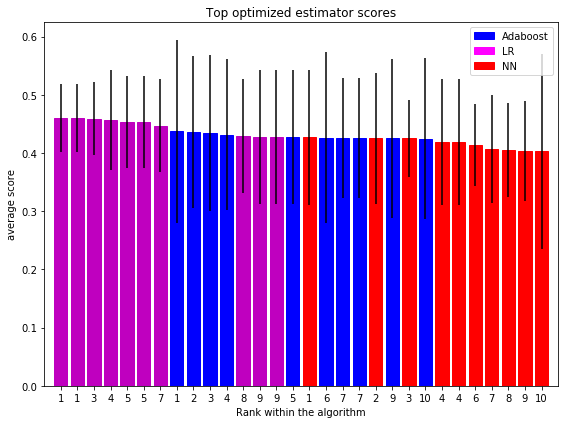

In [33]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    plot_scores(top_scores)

Of the three optimized algorithms Linear Regression gets the highest score as well as the tightest distribution. I will try to understand this one further in [estimator_analysis](estimator_analysis.ipynb)

In [14]:
from sklearn.model_selection import cross_val_score
lr = lr_grid.best_estimator_
lr_roc = cross_val_score(lr, train_features, train_labels, cv=4, scoring='roc_auc')

np.mean(lr_roc)

0.85040087180292168

In [34]:
lr_ap_scores = cross_val_score(lr, train_features, train_labels, cv=4, scoring='average_precision')

print('Area under recall_precision curve is {:.1f} times greater than expected if clasifier were random' 
      .format(np.mean(lr_ap_scores)/(sum(train_labels)/train_labels.shape[0])))

Area under recall_precision curve is 4.4 times greater than expected if clasifier were random


In [35]:
abc_grid.best_params_

{'estimator': AdaBoostClassifier(algorithm='SAMME.R',
           base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=6,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=16,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=42, splitter='best'),
           learning_rate=0.01, n_estimators=25, random_state=42),
 'estimator__base_estimator__max_depth': 6,
 'estimator__base_estimator__min_samples_leaf': 16,
 'estimator__learning_rate': 0.01,
 'estimator__n_estimators': 25}

In [97]:
def plot_val_curve(train_scores, test_scores, xlabel='modified parameter'):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.title("Validation Curve")
    plt.xlabel(xlabel)
    plt.ylabel("Matthews correlation")
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

In [103]:
from sklearn.model_selection import validation_curve

abc = abc_grid.best_estimator_

param_range = [30, 250, 500]

train_scores_01, test_scores_01 = validation_curve(
        abc,
        train_features, train_labels,
        param_name='estimator__n_estimators', 
        param_range=param_range,
        cv=4, scoring=scorer, 
        n_jobs=-1, verbose=2
)

[CV] estimator__n_estimators=30 ......................................
[CV] estimator__n_estimators=250 .....................................
[CV] estimator__n_estimators=500 .....................................
[CV] estimator__n_estimators=30 ......................................
[CV] ....................... estimator__n_estimators=30, total=  28.5s
[CV] estimator__n_estimators=250 .....................................
[CV] ....................... estimator__n_estimators=30, total=  28.5s
[CV] estimator__n_estimators=500 .....................................
[CV] ...................... estimator__n_estimators=250, total= 3.7min
[CV] estimator__n_estimators=30 ......................................
[CV] ...................... estimator__n_estimators=250, total= 3.4min
[CV] estimator__n_estimators=250 .....................................
[CV] ....................... estimator__n_estimators=30, total=  25.2s
[CV] estimator__n_estimators=500 .....................................
[CV] .

[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:  6.9min remaining:  6.9min


[CV] ...................... estimator__n_estimators=500, total= 6.5min
[CV] estimator__n_estimators=250 .....................................
[CV] ....................... estimator__n_estimators=30, total=  29.1s
[CV] estimator__n_estimators=500 .....................................
[CV] ...................... estimator__n_estimators=250, total= 3.4min
[CV] ...................... estimator__n_estimators=500, total= 5.5min
[CV] ...................... estimator__n_estimators=250, total= 2.7min
[CV] ...................... estimator__n_estimators=500, total= 4.0min


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 11.4min finished


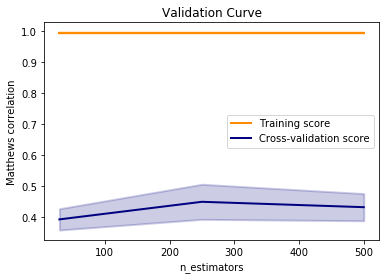

In [104]:
plot_val_curve(train_scores_01, test_scores_01, xlabel='n_estimators')

In [70]:
param_range = [3, 5, 10, 15, 25, 30]

abc.set_params(estimator__learning_rate=1)

train_scores_01, test_scores_01 = validation_curve(
        abc,train_features, train_labels,
        param_name='estimator__n_estimators', 
        param_range=param_range,
        cv=4, scoring=scorer, 
        n_jobs=-1, verbose=2
)

[CV] estimator__n_estimators=3 .......................................
[CV] estimator__n_estimators=5 .......................................
[CV] estimator__n_estimators=10 ......................................
[CV] estimator__n_estimators=15 ......................................
[CV] ........................ estimator__n_estimators=3, total=   3.2s
[CV] estimator__n_estimators=25 ......................................
[CV] ........................ estimator__n_estimators=5, total=   5.1s
[CV] estimator__n_estimators=30 ......................................
[CV] ....................... estimator__n_estimators=10, total=   9.1s
[CV] estimator__n_estimators=3 .......................................
[CV] ........................ estimator__n_estimators=3, total=   3.5s
[CV] estimator__n_estimators=5 .......................................
[CV] ....................... estimator__n_estimators=15, total=  13.8s
[CV] estimator__n_estimators=10 ......................................
[CV] .

[Parallel(n_jobs=-1)]: Done  12 out of  24 | elapsed:   39.1s remaining:   39.1s


[CV] ....................... estimator__n_estimators=10, total=  10.3s
[CV] estimator__n_estimators=25 ......................................
[CV] ....................... estimator__n_estimators=25, total=  23.4s
[CV] estimator__n_estimators=30 ......................................
[CV] ....................... estimator__n_estimators=15, total=  13.7s
[CV] estimator__n_estimators=3 .......................................
[CV] ....................... estimator__n_estimators=30, total=  27.3s
[CV] estimator__n_estimators=5 .......................................
[CV] ........................ estimator__n_estimators=3, total=   4.0s
[CV] estimator__n_estimators=10 ......................................
[CV] ........................ estimator__n_estimators=5, total=   7.0s
[CV] estimator__n_estimators=15 ......................................
[CV] ....................... estimator__n_estimators=10, total=  10.6s
[CV] estimator__n_estimators=25 ......................................
[CV] .

[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  1.4min finished


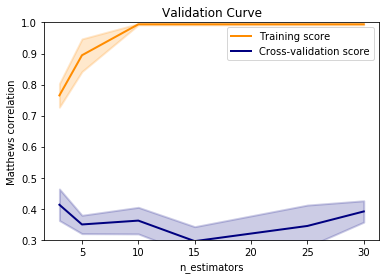

In [72]:
plot_val_curve(train_scores_01, test_score_01, xlabel='n_estimators')

In [73]:
param_range = [30, 60, 120]

abc.set_params(estimator__learning_rate=1)

train_scores_01, test_scores_01 = validation_curve(
        abc,train_features, train_labels,
        param_name='estimator__n_estimators', 
        param_range=param_range,
        cv=4, scoring=scorer, 
        n_jobs=-1, verbose=2
)

[CV] estimator__n_estimators=30 ......................................
[CV] estimator__n_estimators=60 ......................................
[CV] estimator__n_estimators=120 .....................................
[CV] estimator__n_estimators=30 ......................................
[CV] ....................... estimator__n_estimators=30, total=  24.8s
[CV] estimator__n_estimators=60 ......................................
[CV] ....................... estimator__n_estimators=30, total=  24.8s
[CV] estimator__n_estimators=120 .....................................
[CV] ....................... estimator__n_estimators=60, total=  47.6s
[CV] estimator__n_estimators=30 ......................................
[CV] ....................... estimator__n_estimators=60, total=  46.6s
[CV] estimator__n_estimators=60 ......................................
[CV] ....................... estimator__n_estimators=30, total=  26.4s
[CV] estimator__n_estimators=120 .....................................
[CV] .

[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:  1.7min remaining:  1.7min


[CV] ....................... estimator__n_estimators=60, total=  47.4s
[CV] estimator__n_estimators=60 ......................................
[CV] ...................... estimator__n_estimators=120, total= 1.7min
[CV] estimator__n_estimators=120 .....................................
[CV] ....................... estimator__n_estimators=30, total=  27.2s
[CV] ....................... estimator__n_estimators=60, total=  40.7s
[CV] ...................... estimator__n_estimators=120, total= 1.5min
[CV] ...................... estimator__n_estimators=120, total= 1.0min


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  3.1min finished


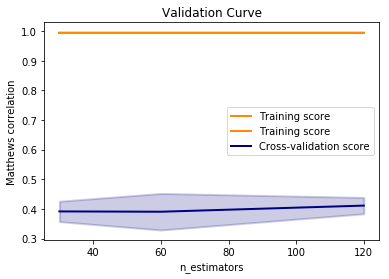

In [76]:
plot_val_curve(train_scores_01, test_scores_01, xlabel='n_estimators')

In [95]:
from sklearn.ensemble import RandomForestClassifier

n_features = train_features.shape[1]

rf = RandomForestClassifier(random_state=42, n_estimators=25)
param_range = np.sqrt(n_features)*np.array([1/4, 1/2, 1, 2, 4, 6])
param_range = np.rint(param_range).astype(int)

train_scores_02, test_scores_02 = validation_curve(
        rf,train_features, train_labels,
        param_name='n_estimators', 
        param_range=param_range,
        cv=4, scoring=scorer, 
        n_jobs=-1, verbose=2
)

[CV] n_estimators=17 .................................................
[CV] n_estimators=33 .................................................
[CV] n_estimators=66 .................................................
[CV] n_estimators=133 ................................................
[CV] .................................. n_estimators=17, total=   0.7s
[CV] n_estimators=266 ................................................
[CV] .................................. n_estimators=33, total=   1.1s
[CV] n_estimators=399 ................................................
[CV] .................................. n_estimators=66, total=   1.7s
[CV] n_estimators=17 .................................................
[CV] .................................. n_estimators=17, total=   0.8s
[CV] n_estimators=33 .................................................
[CV] ................................. n_estimators=133, total=   3.7s
[CV] n_estimators=66 .................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  12 out of  24 | elapsed:   13.5s remaining:   13.5s


[CV] ................................. n_estimators=399, total=  11.8s
[CV] n_estimators=266 ................................................
[CV] ................................. n_estimators=266, total=   7.3s
[CV] n_estimators=399 ................................................
[CV] ................................. n_estimators=133, total=   3.3s
[CV] n_estimators=17 .................................................
[CV] .................................. n_estimators=17, total=   0.6s
[CV] n_estimators=33 .................................................
[CV] .................................. n_estimators=33, total=   0.9s
[CV] n_estimators=66 .................................................
[CV] ................................. n_estimators=399, total=  10.4s
[CV] n_estimators=133 ................................................
[CV] ................................. n_estimators=266, total=   6.9s
[CV] n_estimators=266 ................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   27.6s finished


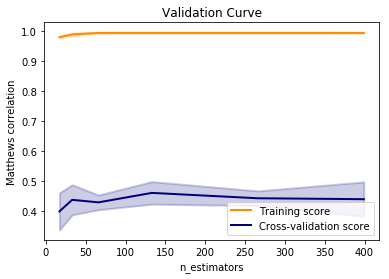

In [96]:
plot_val_curve(train_scores_02, test_scores_02, xlabel='n_estimators')

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

DTC = DecisionTreeClassifier(random_state=42, class_weight='balanced')
ABC = AdaBoostClassifier(base_estimator=DTC, random_state=42)
ABC_params = {'estimator': [ABC],
              'estimator__base_estimator__max_depth': [None, 3, 6, 12, 24, 48],
              'estimator__base_estimator__min_samples_leaf': [1, 2, 4, 8, 16],
              'estimator__n_estimators': [25, 100, 200],
              'estimator__learning_rate': [0.01, 0.1, 1, 10]}

abc_grid = GridSearchCV(pipe,
                        param_grid=ABC_params,
                        cv=4,
                        verbose=2,
                        n_jobs=-1,
                        scoring='f1')

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    abc_grid.fit(train_features, train_labels)